In [513]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import pickle

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [294]:
# Road network data of Seattle city
roads = gpd.read_file('https://opendata.arcgis.com/datasets/383027d103f042499693da22d72d10e3_0.geojson')

In [295]:
# Traffic volume data Seattle city road segments in 2016

volume = gpd.read_file('https://opendata.arcgis.com/datasets/170b764c52f34c9497720c0463f3b58b_9.geojson')

In [296]:
volume.rename(columns={'OBJECTID': 'SEGID'},inplace=True)

In [297]:
acc = pd.read_pickle('data/accident.pickle')

Text(0.5, 1.0, 'Accident map in 2016 Seattle')

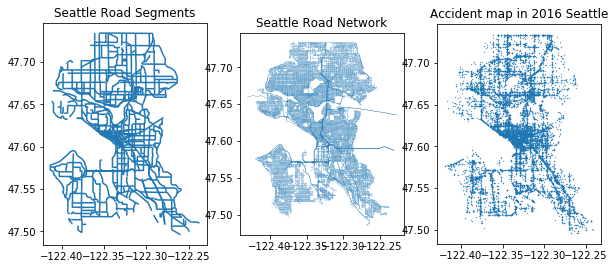

In [653]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize = (10, 8))

volume.plot(ax = ax1)
ax1.set_title('Seattle Road Segments')

roads.plot(ax = ax2, linewidth = 0.3,figsize = (10,8))
ax2.set_title('Seattle Road Network')
acc[acc['year']==2016].plot(ax = ax3,markersize= 0.1, figsize = (10, 8))
plt.title('Accident map in 2016 Seattle')
#plt.xlabel('Longitude')


Text(93.68627283598269, 0.5, 'Latitude')

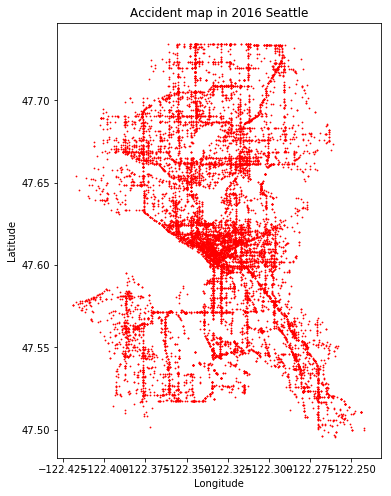

In [649]:
acc[acc['year']==2016].plot(markersize= 0.6, figsize = (8,8), facecolor = 'red')
plt.title('Accident map in 2016 Seattle')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [300]:
roads.columns

Index(['OBJECTID', 'ARTCLASS', 'COMPKEY', 'UNITIDSORT', 'UNITDESC',
       'STNAME_ORD', 'XSTRLO', 'XSTRHI', 'ARTDESCRIPT', 'OWNER', 'STATUS',
       'BLOCKNBR', 'SPEEDLIMIT', 'SEGDIR', 'ONEWAY', 'ONEWAYDIR', 'FLOW',
       'SEGLENGTH', 'SURFACEWIDTH', 'SURFACETYPE_1', 'SURFACETYPE_2', 'INTRLO',
       'DIRLO', 'INTKEYLO', 'INTRHI', 'DIRHI', 'NATIONHWYSYS', 'STREETTYPE',
       'PVMTCONDINDX1', 'PVMTCONDINDX2', 'TRANCLASS', 'TRANDESCRIPT',
       'SLOPE_PCT', 'PVMTCATEGORY', 'PARKBOULEVARD', 'SHAPE_Length',
       'geometry'],
      dtype='object')

In [301]:
volume.columns


Index(['SEGID', 'COUNT_COMPKEY', 'FIRST_STNAME_ORD', 'FIRST_ARTDESCRIPT',
       'FIRST_TRANDESCRIPT', 'COUNTFLAG', 'FLOWSEGID', 'DOWNTOWN',
       'COUNTSTART', 'COUNTAADT', 'COUNTAAWDT', 'ESTIMATE', 'AWDT_ROUND',
       'SHAPE_Length', 'geometry'],
      dtype='object')

In [222]:
# nearest road blocks to each road segment

'''
dist = []
for segment in volume.geometry:
    d = []
    for block in roads.geometry:
        d.append(segment.distance(block))
    d = np.array(d)
    dist.append(d.argmin())
    
'''

'\ndist = []\nfor segment in volume.geometry:\n    d = []\n    for block in roads.geometry:\n        d.append(segment.distance(block))\n    d = np.array(d)\n    dist.append(d.argmin())\n    \n'

In [223]:
# saving minimum distances to a csv file
# np.savetxt('segment_net.csv', dist, fmt="%d", delimiter=",")

In [224]:
# need to come up with a better solutin to assign each road segment to the road network map

""""
dist = []
for idx, segment in enumerate(volume.geometry):
    d = []
    for i, block in enumerate(roads.geometry[:10]):
        d.append(segment.distance(block))
    d = np.array(d)
    for j in d.argsort()[:5]:
        if volume.iloc[j]['FIRST_STNAME_ORD'] == roads.iloc[j]['STNAME_ORD']:
            dist.append(j)
"""

'"\ndist = []\nfor idx, segment in enumerate(volume.geometry):\n    d = []\n    for i, block in enumerate(roads.geometry[:10]):\n        d.append(segment.distance(block))\n    d = np.array(d)\n    for j in d.argsort()[:5]:\n        if volume.iloc[j][\'FIRST_STNAME_ORD\'] == roads.iloc[j][\'STNAME_ORD\']:\n            dist.append(j)\n'

In [302]:
# creating "SEGID" column in network

dist = pd.read_csv('segment_net_indices.csv', header = None).values

network = roads.iloc[dist.flatten()]
network.loc[:, 'SEGID'] = volume['SEGID'].values


/Users/gulomjon/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gulomjon/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [303]:
network.shape


(1865, 38)

In [304]:
network.head()

,OBJECTID,ARTCLASS,COMPKEY,UNITIDSORT,UNITDESC,STNAME_ORD,XSTRLO,XSTRHI,ARTDESCRIPT,OWNER,...,PVMTCONDINDX1,PVMTCONDINDX2,TRANCLASS,TRANDESCRIPT,SLOPE_PCT,PVMTCATEGORY,PARKBOULEVARD,SHAPE_Length,geometry,SEGID
1923,1924,2.0,21309,169700001,S SPOKANE NR ST BETWEEN S SPOKANE ST RP AND EA...,S SPOKANE ST,S SPOKANE ST RP,EAST MARGINAL WAY S,Minor Arterial,,...,91.0,0.0,2,MAJOR TRANSIT ROUTE,0.0,ART,N,927.672370,LINESTRING (-122.3434333838131 47.571579040261...,1
3408,3409,1.0,8766,050650220,ALASKAN WY VI NB BETWEEN EAST MARGINAL WAY S A...,SR99 NB,EAST MARGINAL WAY S,ALASKAN WY VI NB ON RP,Principal Arterial,WSDOT,...,0.0,0.0,2,MAJOR TRANSIT ROUTE,0.0,ART,N,1605.935350,LINESTRING (-122.3394359392448 47.566345148158...,2
3403,3404,3.0,8715,050710010,ALASKAN WY VI SB WSB WB OFF RP BETWEEN ALASKAN...,SR99 SB OFF RP,ALASKAN WY VI SB,WEST SEATTLE BR WB,Collector Arterial,WSDOT,...,100.0,0.0,0,NOT DESIGNATED,0.0,ART,N,1319.086025,LINESTRING (-122.3393934889239 47.573037386120...,3
1923,1924,2.0,21309,169700001,S SPOKANE NR ST BETWEEN S SPOKANE ST RP AND EA...,S SPOKANE ST,S SPOKANE ST RP,EAST MARGINAL WAY S,Minor Arterial,,...,91.0,0.0,2,MAJOR TRANSIT ROUTE,0.0,ART,N,927.672370,LINESTRING (-122.3434333838131 47.571579040261...,4
1922,1923,2.0,21305,169570050,S SPOKANE CR ST BETWEEN S SPOKANE NR ST AND 6T...,S SPOKANE CR ST,S SPOKANE NR ST,6TH AVE S,Minor Arterial,,...,98.0,0.0,2,MAJOR TRANSIT ROUTE,0.0,ART,N,199.159007,LINESTRING (-122.3267633109531 47.571695311514...,5


In [374]:
volume.head()

,SEGID,COUNT_COMPKEY,FIRST_STNAME_ORD,FIRST_ARTDESCRIPT,FIRST_TRANDESCRIPT,COUNTFLAG,FLOWSEGID,DOWNTOWN,COUNTSTART,COUNTAADT,COUNTAAWDT,ESTIMATE,AWDT_ROUND,SHAPE_Length,geometry,count_15,count_16,rate
0,1,None,S SPOKANE ST,None,None,Y,2019.0,N,2015-04-03T00:00:00,5508.833000,6829.504000,None,6800.0,1118.471355,LINESTRING (-122.3396800681195 47.571700326672...,11,7,2.820306e-06
1,3,None,ALASKAN WY VI SB,None,None,Y,2024.0,N,2015-06-09T00:00:00,0.000000,23393.664000,None,23400.0,2441.189454,LINESTRING (-122.3394359390524 47.566345148425...,4,3,3.512469e-07
2,5,None,WEST SEATTLE BR WB,None,None,Y,2026.0,N,2014-04-29T00:00:00,46875.085335,50036.029406,None,50000.0,1817.352489,LINESTRING (-122.333137393517 47.5715774100566...,10,4,2.191781e-07
3,6,None,WEST SEATTLE BR EB,None,None,Y,2027.0,N,None,NaN,35000.000000,Y,35000.0,1423.838986,LINESTRING (-122.3309157221583 47.571518426658...,3,1,7.827789e-08
4,7,None,W SEA BR EB 4 AV OFF RP,None,None,Y,2028.0,N,None,NaN,24000.000000,Y,24000.0,1458.971527,LINESTRING (-122.3309157221583 47.571518426658...,1,2,2.283105e-07


In [306]:
y15 = acc[acc['year']==2015]

In [307]:
y15.shape

(13555, 33)

In [308]:
y16 = acc[acc['year']==2016]

In [309]:
y16.shape

(13233, 33)

In [310]:
# total traffic volume by road segment for 2016 
count16 = y16.groupby('SEGID')['AWDT_ROUND'].count().to_frame(name = 'count')


In [311]:
# total traffic volume by road segment for 2015
count15 = y15.groupby('SEGID')['AWDT_ROUND'].count().to_frame(name = 'count')

In [312]:
two_year = count15.merge(count16, on = 'SEGID')

In [313]:
two_year.rename(columns={'count_x': 'count_15', 'count_y': 'count_16'}, inplace=True)

In [314]:
#volume.drop('count', inplace=True, axis = 1)

In [315]:
volume = volume.merge(two_year, on = 'SEGID')
volume.head()

,SEGID,COUNT_COMPKEY,FIRST_STNAME_ORD,FIRST_ARTDESCRIPT,FIRST_TRANDESCRIPT,COUNTFLAG,FLOWSEGID,DOWNTOWN,COUNTSTART,COUNTAADT,COUNTAAWDT,ESTIMATE,AWDT_ROUND,SHAPE_Length,geometry,count_15,count_16
0,1,None,S SPOKANE ST,None,None,Y,2019.0,N,2015-04-03T00:00:00,5508.833000,6829.504000,None,6800.0,1118.471355,LINESTRING (-122.3396800681195 47.571700326672...,11,7
1,3,None,ALASKAN WY VI SB,None,None,Y,2024.0,N,2015-06-09T00:00:00,0.000000,23393.664000,None,23400.0,2441.189454,LINESTRING (-122.3394359390524 47.566345148425...,4,3
2,5,None,WEST SEATTLE BR WB,None,None,Y,2026.0,N,2014-04-29T00:00:00,46875.085335,50036.029406,None,50000.0,1817.352489,LINESTRING (-122.333137393517 47.5715774100566...,10,4
3,6,None,WEST SEATTLE BR EB,None,None,Y,2027.0,N,None,NaN,35000.000000,Y,35000.0,1423.838986,LINESTRING (-122.3309157221583 47.571518426658...,3,1
4,7,None,W SEA BR EB 4 AV OFF RP,None,None,Y,2028.0,N,None,NaN,24000.000000,Y,24000.0,1458.971527,LINESTRING (-122.3309157221583 47.571518426658...,1,2


In [373]:
#volume['rate'] = volume['count_16']/(volume['AWDT_ROUND']*365)


In [375]:
# final dataframe 
final = volume[['SEGID', 'FIRST_STNAME_ORD', 'AWDT_ROUND','geometry','count_15', 'count_16', 'rate']].merge(network, how = 'left', on = 'SEGID')


In [376]:
final.columns

Index(['SEGID', 'FIRST_STNAME_ORD', 'AWDT_ROUND', 'geometry_x', 'count_15',
       'count_16', 'rate', 'OBJECTID', 'ARTCLASS', 'COMPKEY', 'UNITIDSORT',
       'UNITDESC', 'STNAME_ORD', 'XSTRLO', 'XSTRHI', 'ARTDESCRIPT', 'OWNER',
       'STATUS', 'BLOCKNBR', 'SPEEDLIMIT', 'SEGDIR', 'ONEWAY', 'ONEWAYDIR',
       'FLOW', 'SEGLENGTH', 'SURFACEWIDTH', 'SURFACETYPE_1', 'SURFACETYPE_2',
       'INTRLO', 'DIRLO', 'INTKEYLO', 'INTRHI', 'DIRHI', 'NATIONHWYSYS',
       'STREETTYPE', 'PVMTCONDINDX1', 'PVMTCONDINDX2', 'TRANCLASS',
       'TRANDESCRIPT', 'SLOPE_PCT', 'PVMTCATEGORY', 'PARKBOULEVARD',
       'SHAPE_Length', 'geometry_y'],
      dtype='object')

array(['Y', 'N'], dtype=object)

In [319]:
final.STREETTYPE.unique()

array(['Industrial Access', None, 'Urban Center Connector',
       'Urban Village Main', 'Neighborhood Corridor',
       'Urban Village Neighborhood Access', 'Urban Village Neighborhood',
       'Neighborhood Yield Street', 'Minor Industrial Access', 'Downtown',
       'Downtown Neighborhood', 'Downtown Neighborhood Access', 'Alley'],
      dtype=object)

In [379]:
# creating a column downtown
def downtown(df_in):
    downtown = set(['Downtown', 'Downtown Neighborhood', 'Downtown Neighborhood Access'])
    
    new_df = df_in.copy()
    new_df['downtown'] = df_in['STREETTYPE'].apply(lambda x: 1 if x in downtown else 0)
    #new_df.drop('acct_type', axis=1, inplace=True)
    return new_df

In [380]:
new_final = downtown(final)

In [381]:
# converting ONEWAY column into binary 0 or 1 being 1 downtown
new_final['ONEWAY'] = new_final['ONEWAY'].apply(lambda x: 1 if x == 'Y' else 0)

In [246]:
new_final.columns

Index(['SEGID', 'FIRST_STNAME_ORD', 'AWDT_ROUND', 'geometry_x', 'count_15',
       'count_16', 'OBJECTID', 'ARTCLASS', 'COMPKEY', 'UNITIDSORT', 'UNITDESC',
       'STNAME_ORD', 'XSTRLO', 'XSTRHI', 'ARTDESCRIPT', 'OWNER', 'STATUS',
       'BLOCKNBR', 'SPEEDLIMIT', 'SEGDIR', 'ONEWAY', 'ONEWAYDIR', 'FLOW',
       'SEGLENGTH', 'SURFACEWIDTH', 'SURFACETYPE_1', 'SURFACETYPE_2', 'INTRLO',
       'DIRLO', 'INTKEYLO', 'INTRHI', 'DIRHI', 'NATIONHWYSYS', 'STREETTYPE',
       'PVMTCONDINDX1', 'PVMTCONDINDX2', 'TRANCLASS', 'TRANDESCRIPT',
       'SLOPE_PCT', 'PVMTCATEGORY', 'PARKBOULEVARD', 'SHAPE_Length',
       'geometry_y', 'downtown'],
      dtype='object')

In [382]:
new_final.ONEWAY.unique()

array([1, 0])

In [247]:
sum(new_final.AWDT_ROUND.isna())

2

In [ ]:
# reg_data = new_final[['SPEEDLIMIT', 'SURFACEWIDTH', 'count_15', 'count_16', , 'SLOPE_PCT', 'downtown', 'ONEWAY', 'AWDT_ROUND']]
reg_data.dropna(how = 'all', inplace = True)


In [697]:
reg_data.rename(columns={'AWDT_ROUND': 'ANNUAL_TRAFFIC', 'count_15': 'number_2015','count_16': 'number_2016','SLOPE_PCT':'SLOPE'},inplace=True)



In [699]:
sum(reg_data['SLOPE'].isna())

0

In [700]:
reg_data.loc[:, 'SLOPE'] = reg_data['SLOPE'].fillna(reg_data['SLOPE'].mean())

In [701]:
reg_data.loc[:, 'ANNUAL_TRAFFIC'] = reg_data['ANNUAL_TRAFFIC'].fillna(reg_data['ANNUAL_TRAFFIC'].mean())

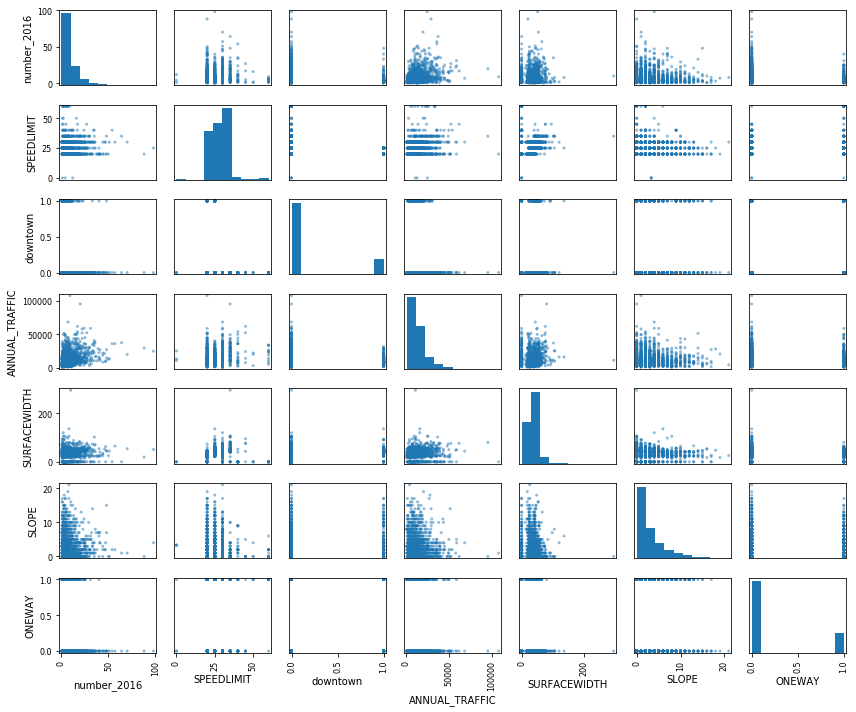

In [731]:
pd.plotting.scatter_matrix(reg_data[['number_2016','SPEEDLIMIT',  'downtown', 'ANNUAL_TRAFFIC', 'SURFACEWIDTH', 'SLOPE', 'ONEWAY']], figsize= (12, 10))
plt.tight_layout()


In [772]:
# Run the regression on year 16

X = reg_data[['number_2015','SPEEDLIMIT',  'downtown', 'ANNUAL_TRAFFIC', 'SURFACEWIDTH', 'SLOPE', 'ONEWAY']]
y = reg_data['number_2016']

In [773]:
X['ADT'] = X['ANNUAL_TRAFFIC']*365

In [774]:
X = X[['number_2015','SPEEDLIMIT',  'downtown', 'SURFACEWIDTH', 'SLOPE', 'ONEWAY', 'ADT']]

In [775]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

In [776]:
X.head()

,number_2015,SPEEDLIMIT,downtown,SURFACEWIDTH,SLOPE,ONEWAY,ADT
0,11,30.0,0,20.0,0.0,1,2482000.0
1,4,30.0,0,33.0,0.0,1,8541000.0
2,10,30.0,0,25.0,0.0,1,18250000.0
3,3,30.0,0,55.0,1.0,1,12775000.0
4,1,35.0,0,77.0,0.0,0,8760000.0


In [777]:
linreg = LinearRegression()
results = linreg.fit(X_train, y_train)

In [778]:
results.score(X_train, y_train)

0.8128250182511376

In [779]:
results.score(X_test, y_test)

0.7134503698174582

In [780]:
mean_squared_error(y_train, results.predict(X_train))**0.5

4.133576623228695

In [782]:
mean_squared_error(y_test, results.predict(X_test))**0.5

4.1290118206548625

In [783]:
# baseline 

In [784]:
y_15 = np.ones(X.shape[0])*reg_data['number_2015']

In [785]:
mean_squared_error(y, reg_data['number_2015'])**0.5

4.31389893800332

In [600]:
# Gradient boosting regressor


In [786]:
gb = GradientBoostingRegressor(alpha = 0.9, learning_rate=0.1)

In [787]:
gb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [788]:
mean_squared_error(y_test, gb.predict(X_test))**0.5

4.21785313209585

In [668]:
# OLS

In [789]:
sm_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [790]:
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            number_2016   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     627.2
Date:                Thu, 11 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:29:16   Log-Likelihood:                -2892.0
No. Observations:                1019   AIC:                             5800.
Df Residuals:                    1011   BIC:                             5839.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.8827      0.695      1.269      0.205      -0.482       2.247
number_2015      0.8830      0.014     61.524      0.000       0.855       0.911
SPEEDLIMIT      -0.0213      0.025     -0.867      0.386      -0.070       0.027
downtown        -0.4535      0.414     -1.096      0.273      -1.265       0.358
SURFACEWIDTH     0.0050      0.007      0.709      0.478      -0.009       0.019
SLOPE           -0.0448      0.039     -1.145      0.253      -0.122       0.032
ONEWAY           0.0140      0.373      0.038      0.970      -0.718       0.747
ADT           1.128e-07    3.8e-08      2.972      0.003    3.83e-08    1.87e-07
==============================================================================
Omnibus:                      110.832   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              367.172
Skew:                           0.509   Prob(JB):                     1.86e-80
Kurtosis:                       5.759   Cond. No.                     3.29e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [806]:
10000000/365

27397.260273972603

In [812]:
X.ADT.min()/365

600.0

In [813]:
rf = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

In [814]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [815]:
mean_squared_error(y_test, rf.predict(X_test))**0.5

4.187681557206429

In [611]:
feature_importance = rf.feature_importances_

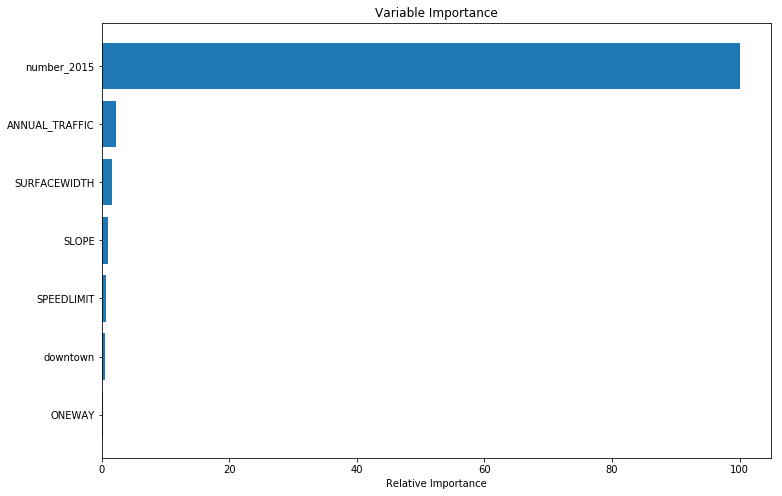

In [727]:
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplots(figsize = (12, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_test.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

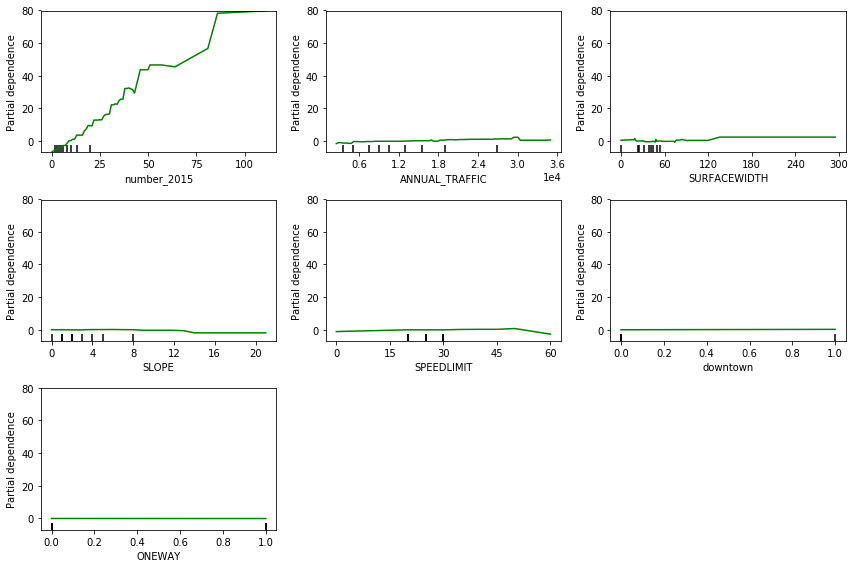

In [735]:
# Partial Dependency Plots
colindex = np.argsort(feature_importance)[::-1]

plot_partial_dependence(gb, X_train, colindex,
                           feature_names = X_train.columns,
                        figsize=(12,8))
plt.tight_layout()




Text(0.5, 1.0, '2015 vs 2016 number of accidents')

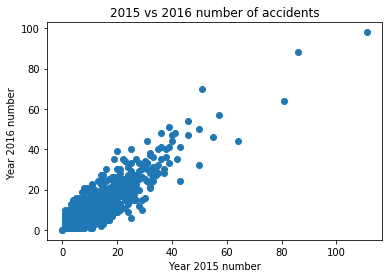

In [619]:
plt.scatter(reg_data.count_15, reg_data.count_16)
plt.xlabel('Year 2015 number')
plt.ylabel('Year 2016 number ')
plt.title('2015 vs 2016 number of accidents')

Text(0.5, 1.0, 'Annual Traffic vs number of accidents')

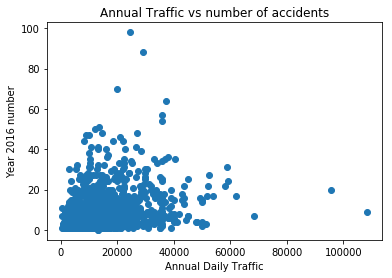

In [624]:
plt.scatter(reg_data.ANNUAL_TRAFFIC, reg_data.count_16)
plt.xlabel('Annual Daily Traffic')
plt.ylabel('Year 2016 number')
plt.title('Annual Traffic vs number of accidents')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b645c50>,
      dtype=object)

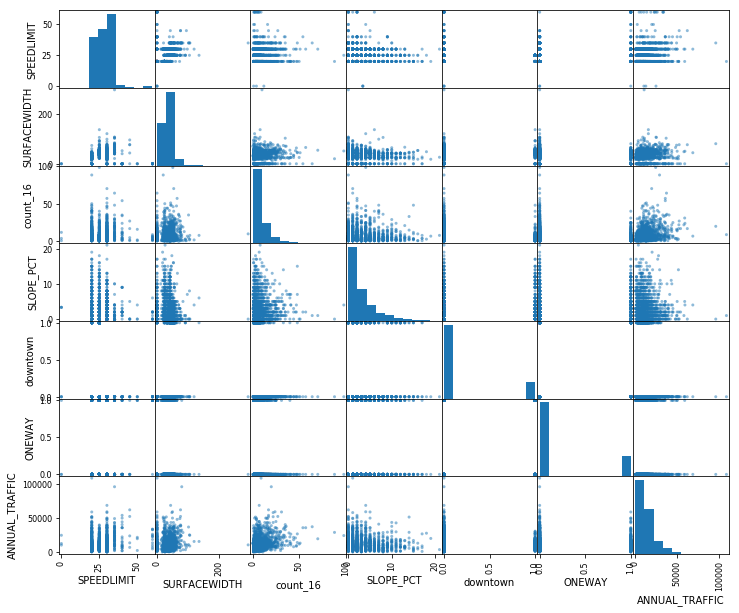

In [629]:
pd.plotting.scatter_matrix(reg_data[['SPEEDLIMIT','SURFACEWIDTH','count_16','SLOPE_PCT','downtown','ONEWAY','ANNUAL_TRAFFIC']], figsize= (12, 10))



In [819]:
reg_data.corr()

,SPEEDLIMIT,SURFACEWIDTH,number_2015,number_2016,SLOPE,downtown,ONEWAY,ANNUAL_TRAFFIC
SPEEDLIMIT,1.000000,0.168681,-0.013375,-0.013967,-0.143463,-0.157958,0.104008,0.139235
SURFACEWIDTH,0.168681,1.000000,-0.001342,0.004010,-0.129647,0.159430,-0.069274,0.068810
number_2015,-0.013375,-0.001342,1.000000,0.886491,-0.044577,-0.172433,-0.185193,0.280217
number_2016,-0.013967,0.004010,0.886491,1.000000,-0.066558,-0.174932,-0.172841,0.296375
SLOPE,-0.143463,-0.129647,-0.044577,-0.066558,1.000000,0.090929,0.052650,-0.102940
downtown,-0.157958,0.159430,-0.172433,-0.174932,0.090929,1.000000,0.440029,-0.099031
ONEWAY,0.104008,-0.069274,-0.185193,-0.172841,0.052650,0.440029,1.000000,-0.039159
ANNUAL_TRAFFIC,0.139235,0.068810,0.280217,0.296375,-0.102940,-0.099031,-0.039159,1.000000
